In [1]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

# Load data

## Basemap UK

<Axes: >

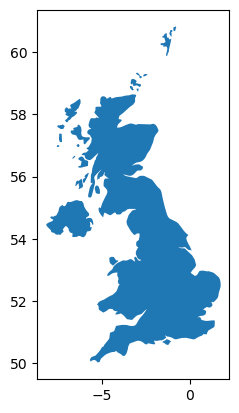

In [12]:
# Load map of UK
world = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\ne_50m_admin_0_countries\\ne_50m_admin_0_countries.shp"))
uk = world[world["ADM0_A3"]=="GBR"]
uk.plot()

In [15]:
## Get Marinas from OSM

#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="United Kingdom"][admin_level=2]->.searchArea;

(node["leisure"="marina"](area.searchArea); 
way["leisure"="marina"](area.searchArea);
rel["leisure"="marina"](area.searchArea);
node["industrial"="port"](area.searchArea); 
way["industrial"="port"](area.searchArea);
rel["industrial"="port"](area.searchArea);
);

out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [58]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "leisure":[], "industrial":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "leisure", "industrial"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

# join into harbour type
gdf["harbour"] = gdf["leisure"] + gdf["industrial"]

(-8.639627299687488, 2.2460404809374994, 49.36949764171875, 61.37771272390625)

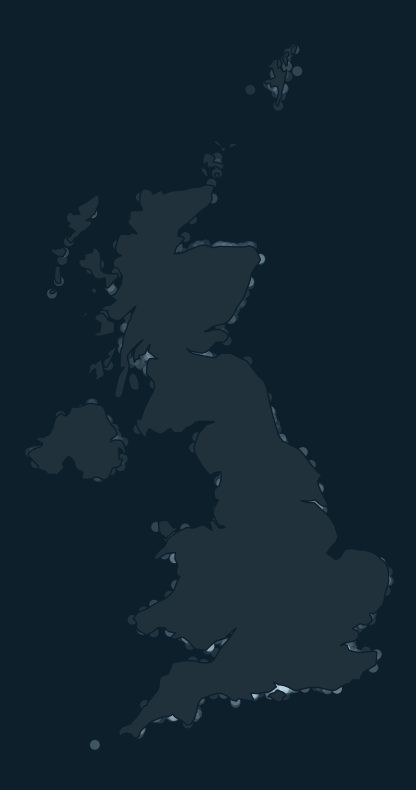

In [57]:
#plot
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor("#0D1F2B")

# ===
# Data
uk.plot(ax=ax, alpha=1, zorder=2, color="#21313C", edgecolor="#0D1F2B")

markers = {"Gelateria": "o", "Gelato": "o", "Other":"o" } # tested different marker shapes 
gdf.plot(ax=ax, zorder=1, markersize=50, edgecolor="None", marker="o", linewidth=0.1, alpha=0.1, color="#CAE8F9")
#gdf.plot(ax=ax, column="harbour", zorder=1, markersize=300, edgecolor="None", marker="o", linewidth=0.1, alpha=0.7, cmap="Blues")
ax.axis("off")


In [ ]:
[out:json];
area[name="United Kingdom"][admin_level=2]->.searchArea;

(way["name"~"Queen"]["highway"](area.searchArea); 
);
out center;